In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import shutil
import random

plt.ion() 

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Data Preparation

In [3]:
data_dir = "/app/var/lib/docker/volumes/parser-lm-wb_parser/_data"
shops = ["lamoda", "wildberries"]
needs_columns = ["gender", "item_id"]

### Lamoda

In [4]:
df_lamoda = pd.read_csv(os.path.join(data_dir, shops[0], "pages_info.tsv"), sep='\t')
df_lamoda = df_lamoda[needs_columns] # Leave the required columns
print(df_lamoda.head(), "\n")
print(df_lamoda.gender.value_counts(), "\n") # Checking for class balance and None values for "gender"
print(df_lamoda[df_lamoda.item_id.isna()], "\n") # Checking None values for "item_id"

    gender       item_id
0  женский  MP002XW05SKP
1  женский  MP002XW0AXLG
2  женский  IX001XW0124K
3  женский  MP002XW088BV
4  женский  MP002XW0995W 

женский    8462
мужской    6144
Name: gender, dtype: int64 

Empty DataFrame
Columns: [gender, item_id]
Index: [] 



In [5]:
lamoda_dir = "/app/var/lib/docker/volumes/parser-lm-wb_parser/_data/lamoda/images"
def set_path(row):
    try:
        f = open(f"{lamoda_dir}/{row['item_id']}.jpg", "rb")
        return f"{lamoda_dir}/{row['item_id']}.jpg"
    except:
        return None

In [6]:
df_lamoda["path"] = df_lamoda.apply(set_path, axis=1)
print(df_lamoda.head(), "\n")
print(df_lamoda[df_lamoda.path.isna()], "\n") # Checking None values for "path"

    gender       item_id                                               path
0  женский  MP002XW05SKP  /app/var/lib/docker/volumes/parser-lm-wb_parse...
1  женский  MP002XW0AXLG  /app/var/lib/docker/volumes/parser-lm-wb_parse...
2  женский  IX001XW0124K  /app/var/lib/docker/volumes/parser-lm-wb_parse...
3  женский  MP002XW088BV  /app/var/lib/docker/volumes/parser-lm-wb_parse...
4  женский  MP002XW0995W  /app/var/lib/docker/volumes/parser-lm-wb_parse... 

Empty DataFrame
Columns: [gender, item_id, path]
Index: [] 



In [7]:
df_lamoda.to_csv("/app/var/lib/docker/volumes/parser-lm-wb_parser/_data/lamoda/preprocessed_pages_info.csv", index=False)

### WB

In [8]:
df_wb = pd.read_csv(os.path.join(data_dir, shops[1], "pages_info.tsv"), sep='\t')
df_wb = df_wb[needs_columns] # Leave the required columns
df_wb = df_wb.drop([5032, 5031], axis="index") # Drop None values
df_wb.item_id = df_wb.item_id.astype(int) # Convert item_id dtype float to int
print(df_wb, "\n")
print(df_wb.gender.value_counts(), "\n") # Checking for class balance and None values for "gender"
print(df_wb[df_wb.item_id.isna()], "\n") # Checking None values for "item_id"

        gender   item_id
0      женский  50657246
1      женский  47948293
2      женский  39213396
3      женский  10147914
4      женский  33565132
...        ...       ...
16925  мужской  49926538
16926  мужской  24774833
16927  мужской   6260838
16928  мужской  43735073
16929  мужской  46099479

[16928 rows x 2 columns] 

женский    10044
мужской     6884
Name: gender, dtype: int64 

Empty DataFrame
Columns: [gender, item_id]
Index: [] 



In [9]:
wb_dir = "/app/var/lib/docker/volumes/parser-lm-wb_parser/_data/wildberries/images"
def set_path(row):
    try:
        f = open(f"{wb_dir}/{row['item_id']}.jpg", "rb")
        return f"{wb_dir}/{row['item_id']}.jpg"
    except:
        return None

In [10]:
df_wb["path"] = df_wb.apply(set_path, axis=1)
print(df_wb.head(), "\n")
print(df_wb[df_wb.path.isna()], "\n") # Checking None values for "path"

    gender   item_id                                               path
0  женский  50657246  /app/var/lib/docker/volumes/parser-lm-wb_parse...
1  женский  47948293  /app/var/lib/docker/volumes/parser-lm-wb_parse...
2  женский  39213396  /app/var/lib/docker/volumes/parser-lm-wb_parse...
3  женский  10147914  /app/var/lib/docker/volumes/parser-lm-wb_parse...
4  женский  33565132  /app/var/lib/docker/volumes/parser-lm-wb_parse... 

Empty DataFrame
Columns: [gender, item_id, path]
Index: [] 



In [11]:
df_wb.to_csv("/app/var/lib/docker/volumes/parser-lm-wb_parser/_data/wildberries/preprocessed_pages_info.csv", index=False)

### Concat data

In [12]:
df = pd.concat([df_wb, df_lamoda], axis=0, ignore_index=True)
df.to_csv("/app/data.csv", index=False)

### Set up folders

In [13]:
df.gender.value_counts()

женский    18506
мужской    13028
Name: gender, dtype: int64

In [14]:
# pretrained man: 75/18/8
#          woman: 72/22/6

In [15]:
df_man = df[df.gender == "мужской"]
df_man

,gender,item_id,path
10044,мужской,51016215,/app/var/lib/docker/volumes/parser-lm-wb_parse...
10045,мужской,51583008,/app/var/lib/docker/volumes/parser-lm-wb_parse...
10046,мужской,16509870,/app/var/lib/docker/volumes/parser-lm-wb_parse...
10047,мужской,16509866,/app/var/lib/docker/volumes/parser-lm-wb_parse...
10048,мужской,8550041,/app/var/lib/docker/volumes/parser-lm-wb_parse...
...,...,...,...
31529,мужской,RTLAAT971501,/app/var/lib/docker/volumes/parser-lm-wb_parse...
31530,мужской,MP002XM1H37W,/app/var/lib/docker/volumes/parser-lm-wb_parse...
31531,мужской,MA991EMBQZU0,/app/var/lib/docker/volumes/parser-lm-wb_parse...
31532,мужской,MP002XM1GZ8C,/app/var/lib/docker/volumes/parser-lm-wb_parse...


In [16]:
df_woman = df[df.gender == "женский"]
df_woman

,gender,item_id,path
0,женский,50657246,/app/var/lib/docker/volumes/parser-lm-wb_parse...
1,женский,47948293,/app/var/lib/docker/volumes/parser-lm-wb_parse...
2,женский,39213396,/app/var/lib/docker/volumes/parser-lm-wb_parse...
3,женский,10147914,/app/var/lib/docker/volumes/parser-lm-wb_parse...
4,женский,33565132,/app/var/lib/docker/volumes/parser-lm-wb_parse...
...,...,...,...
25385,женский,MP002XW07U11,/app/var/lib/docker/volumes/parser-lm-wb_parse...
25386,женский,IX001XW01428,/app/var/lib/docker/volumes/parser-lm-wb_parse...
25387,женский,MP002XW07OLU,/app/var/lib/docker/volumes/parser-lm-wb_parse...
25388,женский,RTLAAZ668501,/app/var/lib/docker/volumes/parser-lm-wb_parse...


In [17]:
woman_list = df_woman.path.tolist()
man_list = df_man.path.tolist()

In [18]:
random.shuffle(woman_list)
random.shuffle(man_list)

In [19]:
# split 75/15/10
train_woman_list = woman_list[:13880]
valid_woman_list = woman_list[13880:16656]
test_woman_list = woman_list[16656:]

train_man_list = man_list[:9771]
valid_man_list = man_list[9771:11725]
test_man_list = man_list[11725:]

In [ ]:
for f in train_woman_list:
    shutil.copyfile(f, f"/app/data/train/woman/{f.split('/')[-1]}")
for f in valid_woman_list:
    shutil.copyfile(f, f"/app/data/valid/woman/{f.split('/')[-1]}")
for f in test_woman_list:
    shutil.copyfile(f, f"/app/data/test/woman/{f.split('/')[-1]}")
    
for f in train_man_list:
    shutil.copyfile(f, f"/app/data/train/man/{f.split('/')[-1]}")
for f in valid_man_list:
    shutil.copyfile(f, f"/app/data/valid/man/{f.split('/')[-1]}")
for f in test_man_list:
    shutil.copyfile(f, f"/app/data/test/man/{f.split('/')[-1]}")

### Celeb dataset

In [20]:
df_celeb_man = pd.read_csv("/app/celeb_man.csv", header=None)
df_celeb_man

,0,1,2
0,Григорий Лепс,мужской,/opt/celebs/static/celebs/Григорий Лепс/bc29c9...
1,Данила Козловский,мужской,/opt/celebs/static/celebs/Данила Козловский/60...
2,Павел Воля,мужской,/opt/celebs/static/celebs/Павел Воля/60319c9fc...
3,Павел Деревянко,мужской,/opt/celebs/static/celebs/Павел Деревянко/1e46...
4,Александр Паль,мужской,/opt/celebs/static/celebs/Александр Паль/2924f...
...,...,...,...
995,Павел Воля,мужской,/opt/celebs/static/celebs/Павел Воля/150e9584e...
996,Баста,мужской,/opt/celebs/static/celebs/Баста/8f21c52249004b...
997,Семен Слепаков,мужской,/opt/celebs/static/celebs/Семен Слепаков/3e7b8...
998,Иван Ургант,мужской,/opt/celebs/static/celebs/Иван Ургант/0a1c935f...


In [21]:
df_celeb_woman = pd.read_csv("/app/celeb_woman.csv", header=None)
df_celeb_woman

,0,1,2
0,Vogue France,женский,/opt/celebs/static/celebs/Vogue France/27026d4...
1,Олеся Фаттахова,женский,/opt/celebs/static/celebs/Олеся Фаттахова/b868...
2,Анна Семенович,женский,/opt/celebs/static/celebs/Анна Семенович/cd130...
3,Яна Рудковская,женский,/opt/celebs/static/celebs/Яна Рудковская/6c9d6...
4,Ekaterina Mtsituridze,женский,/opt/celebs/static/celebs/Ekaterina Mtsituridz...
...,...,...,...
995,Karina Paletskikh,женский,/opt/celebs/static/celebs/Karina Paletskikh/2a...
996,Miranda Cosgrove,женский,/opt/celebs/static/celebs/Miranda Cosgrove/f0e...
997,Алсу,женский,/opt/celebs/static/celebs/Алсу/75b235aebf5e484...
998,Ксения Бородина,женский,/opt/celebs/static/celebs/Ксения Бородина/6432...


In [22]:
celeb_woman_list = df_celeb_woman[2].tolist()
celeb_man_list = df_celeb_man[2].tolist()

In [23]:
random.shuffle(celeb_woman_list)
random.shuffle(celeb_man_list)

In [24]:
train_celeb_woman_list = celeb_woman_list[:750]
valid_celeb_woman_list = celeb_woman_list[750:900]
test_celeb_woman_list = celeb_woman_list[900:]

train_celeb_man_list = celeb_man_list[:750]
valid_celeb_man_list = celeb_man_list[750:900]
test_celeb_man_list = celeb_man_list[900:]

In [ ]:
for f in train_celeb_woman_list:
    try:
        shutil.copyfile("/app" + f[11:], f"/app/data/train/woman/{f.split('/')[-1]}")
    except:
        continue
for f in valid_celeb_woman_list:
    try:
        shutil.copyfile("/app" + f[11:], f"/app/data/valid/woman/{f.split('/')[-1]}")
    except:
        continue
for f in test_celeb_woman_list:
    try:
        shutil.copyfile("/app" + f[11:], f"/app/data/test/woman/{f.split('/')[-1]}")
    except:
        continue
    
for f in train_celeb_man_list:
    try:
        shutil.copyfile("/app" + f[11:], f"/app/data/train/man/{f.split('/')[-1]}")
    except:
        continue
for f in valid_celeb_man_list:
    try:
        shutil.copyfile("/app" + f[11:], f"/app/data/valid/man/{f.split('/')[-1]}")
    except:
        continue
for f in test_celeb_man_list:
    try:
        shutil.copyfile("/app" + f[11:], f"/app/data/test/man/{f.split('/')[-1]}")
    except:
        continue

In the code above, I have collected all the available data in the format for the datasets.ImageFolder class and divided them in a 75/15/10 ratio. The target classes are "nearly" balanced.

# Train

In [25]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', "test"]}

In [26]:
image_datasets['valid'].targets = torch.tensor(image_datasets['valid'].targets)
image_datasets['valid'].targets[image_datasets['valid'].targets == 1] = 0
image_datasets['valid'].targets[image_datasets['valid'].targets == 2] = 1
image_datasets['valid'].targets = image_datasets['valid'].targets.tolist()

image_datasets['test'].targets = torch.tensor(image_datasets['test'].targets)
image_datasets['test'].targets[image_datasets['test'].targets == 1] = 0
image_datasets['test'].targets[image_datasets['test'].targets == 2] = 1
image_datasets['test'].targets = image_datasets['test'].targets.tolist()

In [27]:
dataloader_train = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=10) for x in ['train']}
dataloader_valid = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=False, num_workers=10) for x in ['valid']}
dataloader_test = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=10) for x in ['test']}

dataloaders = {**dataloader_train, **dataloader_valid, **dataloader_test}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', "test"]}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

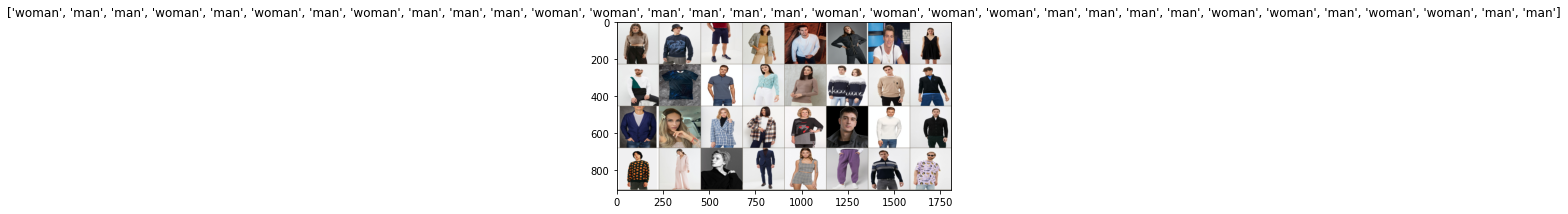

In [28]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
#                     if phase == 'valid': # Second override of target classes, causing all classes to be 0
#                         labels[labels == 1] = 0
#                         labels[labels == 2] = 1
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [30]:
checkpoint_path = "/app/gender_classifier_lite.pth"
model_ft = models.mobilenet_v2(pretrained=False)
model_ft.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)
model_ft.load_state_dict(torch.load(checkpoint_path))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001) # Reduced learning rate for finetune model

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [31]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.0874 Acc: 0.9746
valid Loss: 0.0728 Acc: 0.9731

Epoch 1/14
----------
train Loss: 0.0519 Acc: 0.9820
valid Loss: 0.0624 Acc: 0.9757

Epoch 2/14
----------
train Loss: 0.0389 Acc: 0.9872
valid Loss: 0.0600 Acc: 0.9789

Epoch 3/14
----------
train Loss: 0.0308 Acc: 0.9892
valid Loss: 0.0582 Acc: 0.9809

Epoch 4/14
----------
train Loss: 0.0225 Acc: 0.9932
valid Loss: 0.0577 Acc: 0.9805

Epoch 5/14
----------
train Loss: 0.0162 Acc: 0.9956
valid Loss: 0.0566 Acc: 0.9817

Epoch 6/14
----------
train Loss: 0.0158 Acc: 0.9956
valid Loss: 0.0603 Acc: 0.9815

Epoch 7/14
----------
train Loss: 0.0147 Acc: 0.9963
valid Loss: 0.0594 Acc: 0.9815

Epoch 8/14
----------
train Loss: 0.0147 Acc: 0.9959
valid Loss: 0.0594 Acc: 0.9811

Epoch 9/14
----------
train Loss: 0.0131 Acc: 0.9966
valid Loss: 0.0595 Acc: 0.9817

Epoch 10/14
----------
train Loss: 0.0131 Acc: 0.9964
valid Loss: 0.0601 Acc: 0.9811

Epoch 11/14
----------
train Loss: 0.0136 Acc: 0.9963
valid Loss

In [32]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

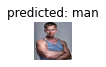

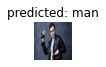

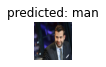

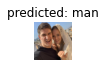

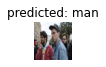

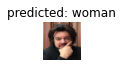

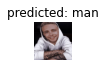

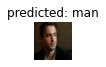

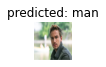

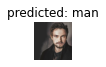

In [33]:
visualize_model(model_ft)

In [34]:
torch.save(model_ft.state_dict(), 'gender_v1.pth')

# Test Model

In [35]:
test_ch_path = "/app/gender_v1.pth"

In [36]:
test_model = models.mobilenet_v2(pretrained=False)
test_model.classifier[1] = nn.Linear(in_features=1280, out_features=2, bias=True)
test_model = test_model.to(device)
test_model.load_state_dict(torch.load(test_ch_path))
test_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [37]:
running_corrects = 0
for inputs, labels in dataloaders["test"]:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    # track history if only in train
    with torch.no_grad():
        outputs = test_model(inputs)
        _, preds = torch.max(outputs, 1)

    # statistics
    running_corrects += torch.sum(preds == labels.data)
epoch_acc = running_corrects.double() / dataset_sizes["test"]

print('Acc: {:.4f}'.format(epoch_acc))

Acc: 0.9794


# Preparing a model for deployment

### Model quantization

In [38]:
import torch.quantization
quantized_model = torch.quantization.quantize_dynamic(test_model.cpu(), {torch.nn.Linear}, dtype=torch.qint8)

### Post-quantization accuracy check

In [39]:
running_corrects = 0
for inputs, labels in dataloaders["test"]:
    inputs = inputs
    labels = labels

    # forward
    # track history if only in train
    with torch.no_grad():
        outputs = quantized_model(inputs)
        _, preds = torch.max(outputs, 1)

    # statistics
    running_corrects += torch.sum(preds == labels.data)
epoch_acc = running_corrects.double() / dataset_sizes["test"]

print('Acc: {:.4f}'.format(epoch_acc))

Acc: 0.9794


### Convert the quantized model to the TorchScript format

In [40]:
torchscript_model = torch.jit.script(quantized_model)

### Optimize the TorchScript formatted model for mobile and save it

In [41]:
from torch.utils.mobile_optimizer import optimize_for_mobile
torchscript_model_optimized = optimize_for_mobile(torchscript_model)
torch.jit.save(torchscript_model_optimized, "mobilenetv2_quantized.pt")

# Below are the instructions for using the model on mobile devices.

## Add the Model and PyTorch Library on iOS

To use the mobile-ready model mobilenetv2_quantized.pt in an iOS app, either create a new Xcode project or in your existing Xcode project, then follow the steps below:
- Open a Mac Terminal, cd to your iOS app’s project folder;
- If your iOS app does not use Cocoapods yet, run pod init first to generate the Podfile file.
- Edit Podfile either from Xcode or any editor, and add the following line under the target:

```swift
pod 'LibTorch', '~>1.6.1'
```

- Run pod install from the Terminal and then open your project’s xcworkspace file;
- Save the two files TorchModule.h and TorchModule.mm from [here](https://github.com/pytorch/ios-demo-app/tree/master/HelloWorld/HelloWorld/HelloWorld/TorchBridge) and drag and drop them to your project. If your project is Swift based, a message box with the title “Would you like to configure an Objective-C bridging header?” will show up; click the “Create Bridging Header” button to create a Swift to Objective-c bridging header file, and add #import “TorchModule.h” to the header file <your_project_name>-Bridging-Header.h;
- Drag and drop the model file mobilenetv2_quantized.pt to the project.

After these steps, you can successfully build and run your Xcode project. To actually write code to use the model, refer to the PyTorch Mobile [iOS Code Walkthrough](https://pytorch.org/mobile/ios/#code-walkthrough) and two complete ready-to-run sample iOS apps [HelloWorld](https://github.com/pytorch/ios-demo-app/tree/master/HelloWorld) and [iOS Hackathon Example](https://github.com/pytorch/workshops/tree/master/PTMobileWalkthruIOS).

## Add the Model and PyTorch Library on Android

- In your current or a new Android Studio project, open the build.gradle file, and add the following two lines (the second one is required only if you plan to use a TorchVision model):

```java
implementation 'org.pytorch:pytorch_android:1.6.0'
implementation 'org.pytorch:pytorch_android_torchvision:1.6.0'
```

- Drag and drop the model file mobilenetv2_quantized.pt to your project’s assets folder.

That’s it! Now you can build your Android app with the PyTorch library and the model ready to use. To actually write code to use the model, refer to the PyTorch Mobile [Android Quickstart with a HelloWorld Example](https://pytorch.org/mobile/android/#quickstart-with-a-helloworld-example) and [Android Hackathon Example](https://github.com/pytorch/workshops/tree/master/PTMobileWalkthruAndroid).